# How are spatial positions affected by binaries and the presence of a potential?

## The goal and plan

In this case study, the question we want to answer is **"how do binary interactions and the galactic potential impact the final positions of massive stars?"**. In order to do this, let's compare the final galactocentric $x$ and $z$ positions of massive stars at present day (i.e. stars with more than $7 {\rm M_\odot}$ and a stellar type less than $10$) for:

- Single stars
- Binary stars
- Binary stars without a galactic potential

In [1]:
import cogsworth
import numpy as np
import astropy.units as u
import gala.potential as gp
from gala.units import galactic
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 20

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': 0.7 * fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.7 * fs,
          'ytick.labelsize': 0.7 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

## Simulate the population
To start, let's simulate the population. Specifically, let's simulate a population of stars formed in the last 100 million years in the Milky Way with a binary fraction of 50% so we can compare single and binary stars.

In [3]:
# only want the last 100 Myr of star formation
max_ev_time = 100 * u.Myr

In [4]:
# define a simple SFH that is identical to Wagg2022 but only forms stars in the last 100 Myr
class RecentHistory(cogsworth.sfh.Wagg2022):
    def __init__(self, components=["low_alpha_disc"], component_masses=[1], **kwargs):
        super().__init__(components=components, component_masses=component_masses, **kwargs)

    def draw_lookback_times(self, size=None, component="low_alpha_disc"):
        U = np.random.rand(size)
        norm = 1 / (self.tsfr * np.exp(-self.galaxy_age / self.tsfr) * (np.exp(max_ev_time / self.tsfr) - 1))
        tau = self.tsfr * np.log((U * np.exp(self.galaxy_age / self.tsfr)) / (norm * self.tsfr) + 1)
        return tau

The next cell is where the main computation happens for this case study, it takes about 5 minutes to run on my laptop.

In [5]:
# this conditions is just to avoid re-running the simulation every time
if os.path.exists("bin_pot_effects.h5"):
    p = cogsworth.pop.load("bin_pot_effects.h5", parts=["initial_binaries", "initial_galaxy",
                                                        "stellar_evolution", "galactic_orbits"])
else:
    p = cogsworth.pop.Population(
        n_binaries=2_000_000,
        processes=6,
        m1_cutoff=7,               # we're only interested in massive stars
        max_ev_time=max_ev_time,   # only the last 100 Myr of star formation
        BSE_settings={
            "binfrac": 0.5         # 50% binary fraction gives us a good mix of single and binary stars
        },
        store_entire_orbits=False, # we don't need the full orbits, just final positions
        sfh_model=RecentHistory,   # use our custom SFH model
        sampling_params={
            "keep_singles": True   # keep single stars in the population
        }
    )
    p.create_population()
    p.save("bin_pot_effects.h5")

### Repeat without the potential

Now let's create a copy of this population that evolves systems with a ``Null`` galactic potential and removes their initial velocities. This means that stars that receive no kick will remain in their formation location and kicked systems will move off in a straight line.

In [20]:
# copy the populations
p_no_potential = p[:]

# remove the potential
p_no_potential.galactic_potential = gp.NullPotential(units=galactic)

# reset the initial velocities
p_no_potential.initial_galaxy.v_R = np.zeros_like(p_no_potential.initial_galaxy.v_R)
p_no_potential.initial_galaxy.v_T = np.zeros_like(p_no_potential.initial_galaxy.v_T)
p_no_potential.initial_galaxy.v_z = np.zeros_like(p_no_potential.initial_galaxy.v_z)

# integrate the orbits
p_no_potential.perform_galactic_evolution(quiet=True)

71504it [00:41, 1743.30it/s]                            


## Get present day positions of stars

Now we need some functions to split the populations into the correct subpopulations and also a way to access the final positions of only stars.

In [6]:
KSTAR_MAX = 10

def get_x_z(p):
    """Get the final x-z positions of the stars in the population"""
    # bound systems need at least one star
    bound_pos = p.final_pos[:len(p)][~p.disrupted & ((p.final_bpp["kstar_1"] <= KSTAR_MAX)
                                                   | (p.final_bpp["kstar_2"] <= KSTAR_MAX))]
    # disrupted primary (secondary) systems need the primary (secondary) to be a star
    dis_pos_1 = p.final_pos[:len(p)][p.disrupted & (p.final_bpp["kstar_1"] <= KSTAR_MAX)]
    dis_pos_2 = p.final_pos[len(p):][p.final_bpp["kstar_2"][p.disrupted] <= KSTAR_MAX]

    # combine them all and return x, z
    all_pos = np.concatenate([bound_pos, dis_pos_1, dis_pos_2])
    return all_pos[:, 0], all_pos[:, 2]

In [21]:
# split up the populations
singles = p[p.initC["kstar_2"] == 15]
binaries = p[p.initC["kstar_2"] != 15]
binaries_no_pot = p_no_potential[p_no_potential.initC["kstar_2"] != 15]

## Visualise the results

We'll visualise this with a single density plot using a Kernel Density Estimator (KDE). Scipy provides a
simple gaussian one and we can build around it to mirror the density on the plot.

### Calculate densities for each population

This uses the ``scipy`` ``gaussian_kde`` function to calculate the overall $x$-$z$ density and then reflects it into a specific half/quadrant depending on user input

In [13]:
from scipy.stats import gaussian_kde

def get_mirrored_density(x, y, x_range, y_range, mirror_x=None, mirror_y=None):
    """Get the mirrored density of a 2D distribution"""
    X, Y = np.meshgrid(x_range, y_range)
    densities = gaussian_kde([x, y]).evaluate([X.flatten(), Y.flatten()]).reshape((len(x_range), len(y_range)))
    
    # mirror left or right if requested
    if mirror_x == "left":
        densities = np.where(X <= 0, densities + np.fliplr(densities), 0)
    elif mirror_x == "right":
        densities = np.where(X >= 0, densities + np.fliplr(densities), 0)
    
    # mirror up or down if requested
    if mirror_y == "up":
        densities = np.where(Y >= 0, densities + np.flipud(densities), 0)
    elif mirror_y == "down":
        densities = np.where(Y <= 0, densities + np.flipud(densities), 0)
        
    return X, Y, densities

We can apply the function to each of the subpopulations with different inputs using the following loop

In [15]:
# define the range we want to plot
x_range = np.linspace(-30, 30, 100) * u.kpc
z_range = np.linspace(-6, 6, 100) * u.kpc

# set up a dictionary to store the data
data = {
    "singles": {},
    "binaries": {},
    "binaries_no_pot": {}
}

# loop over the populations and get the density (mirrored in the correct way)
for pop, label, mirror_x, mirror_y in zip([singles, binaries, binaries_no_pot],
                                          ["singles", "binaries", "binaries_no_pot"],
                                          ["left", "right", "right"],
                                          [None, "up", "down"]):
    # get the x and z positions
    x, z = get_x_z(pop)
    # only keep the stars within the range we want to plot
    x, z = x[(x >= x_range.min()) & (x <= x_range.max()) & (z >= z_range.min()) & (z <= z_range.max())],\
        z[(z >= z_range.min()) & (z <= z_range.max()) & (x >= x_range.min()) & (x <= x_range.max())]
    
    # get the mirrored density
    X, Z, data[label]["density"] = get_mirrored_density(x, z,
                                                        x_range, z_range, mirror_x, mirror_y)
    
    # store the x and z positions as well
    data[label]["x"], data[label]["z"] = x, z

### Plot the densities

Now let's make a nice plot showing the density distributions! This plot shows the 2D density distribution up to the 98th percentile, with the remaining outliers plotted with scatter points. There's also a marginal distribution showing the KDE in $z$ for each of the populations.

In [16]:
def _iso_level_to_levels(data, iso_levels):
    # convert a list of isoprobability levels to actual levels for contourf plots
    # (don't worry too much about the details here ;) )
    isoprop = np.asarray(iso_levels)
    values = np.ravel(data)
    sorted_values = np.sort(values)[::-1]
    normalized_values = np.cumsum(sorted_values) / values.sum()
    idx = np.searchsorted(normalized_values, 1 - isoprop)
    levels = np.take(sorted_values, idx, mode="clip")
    return np.unique(levels)

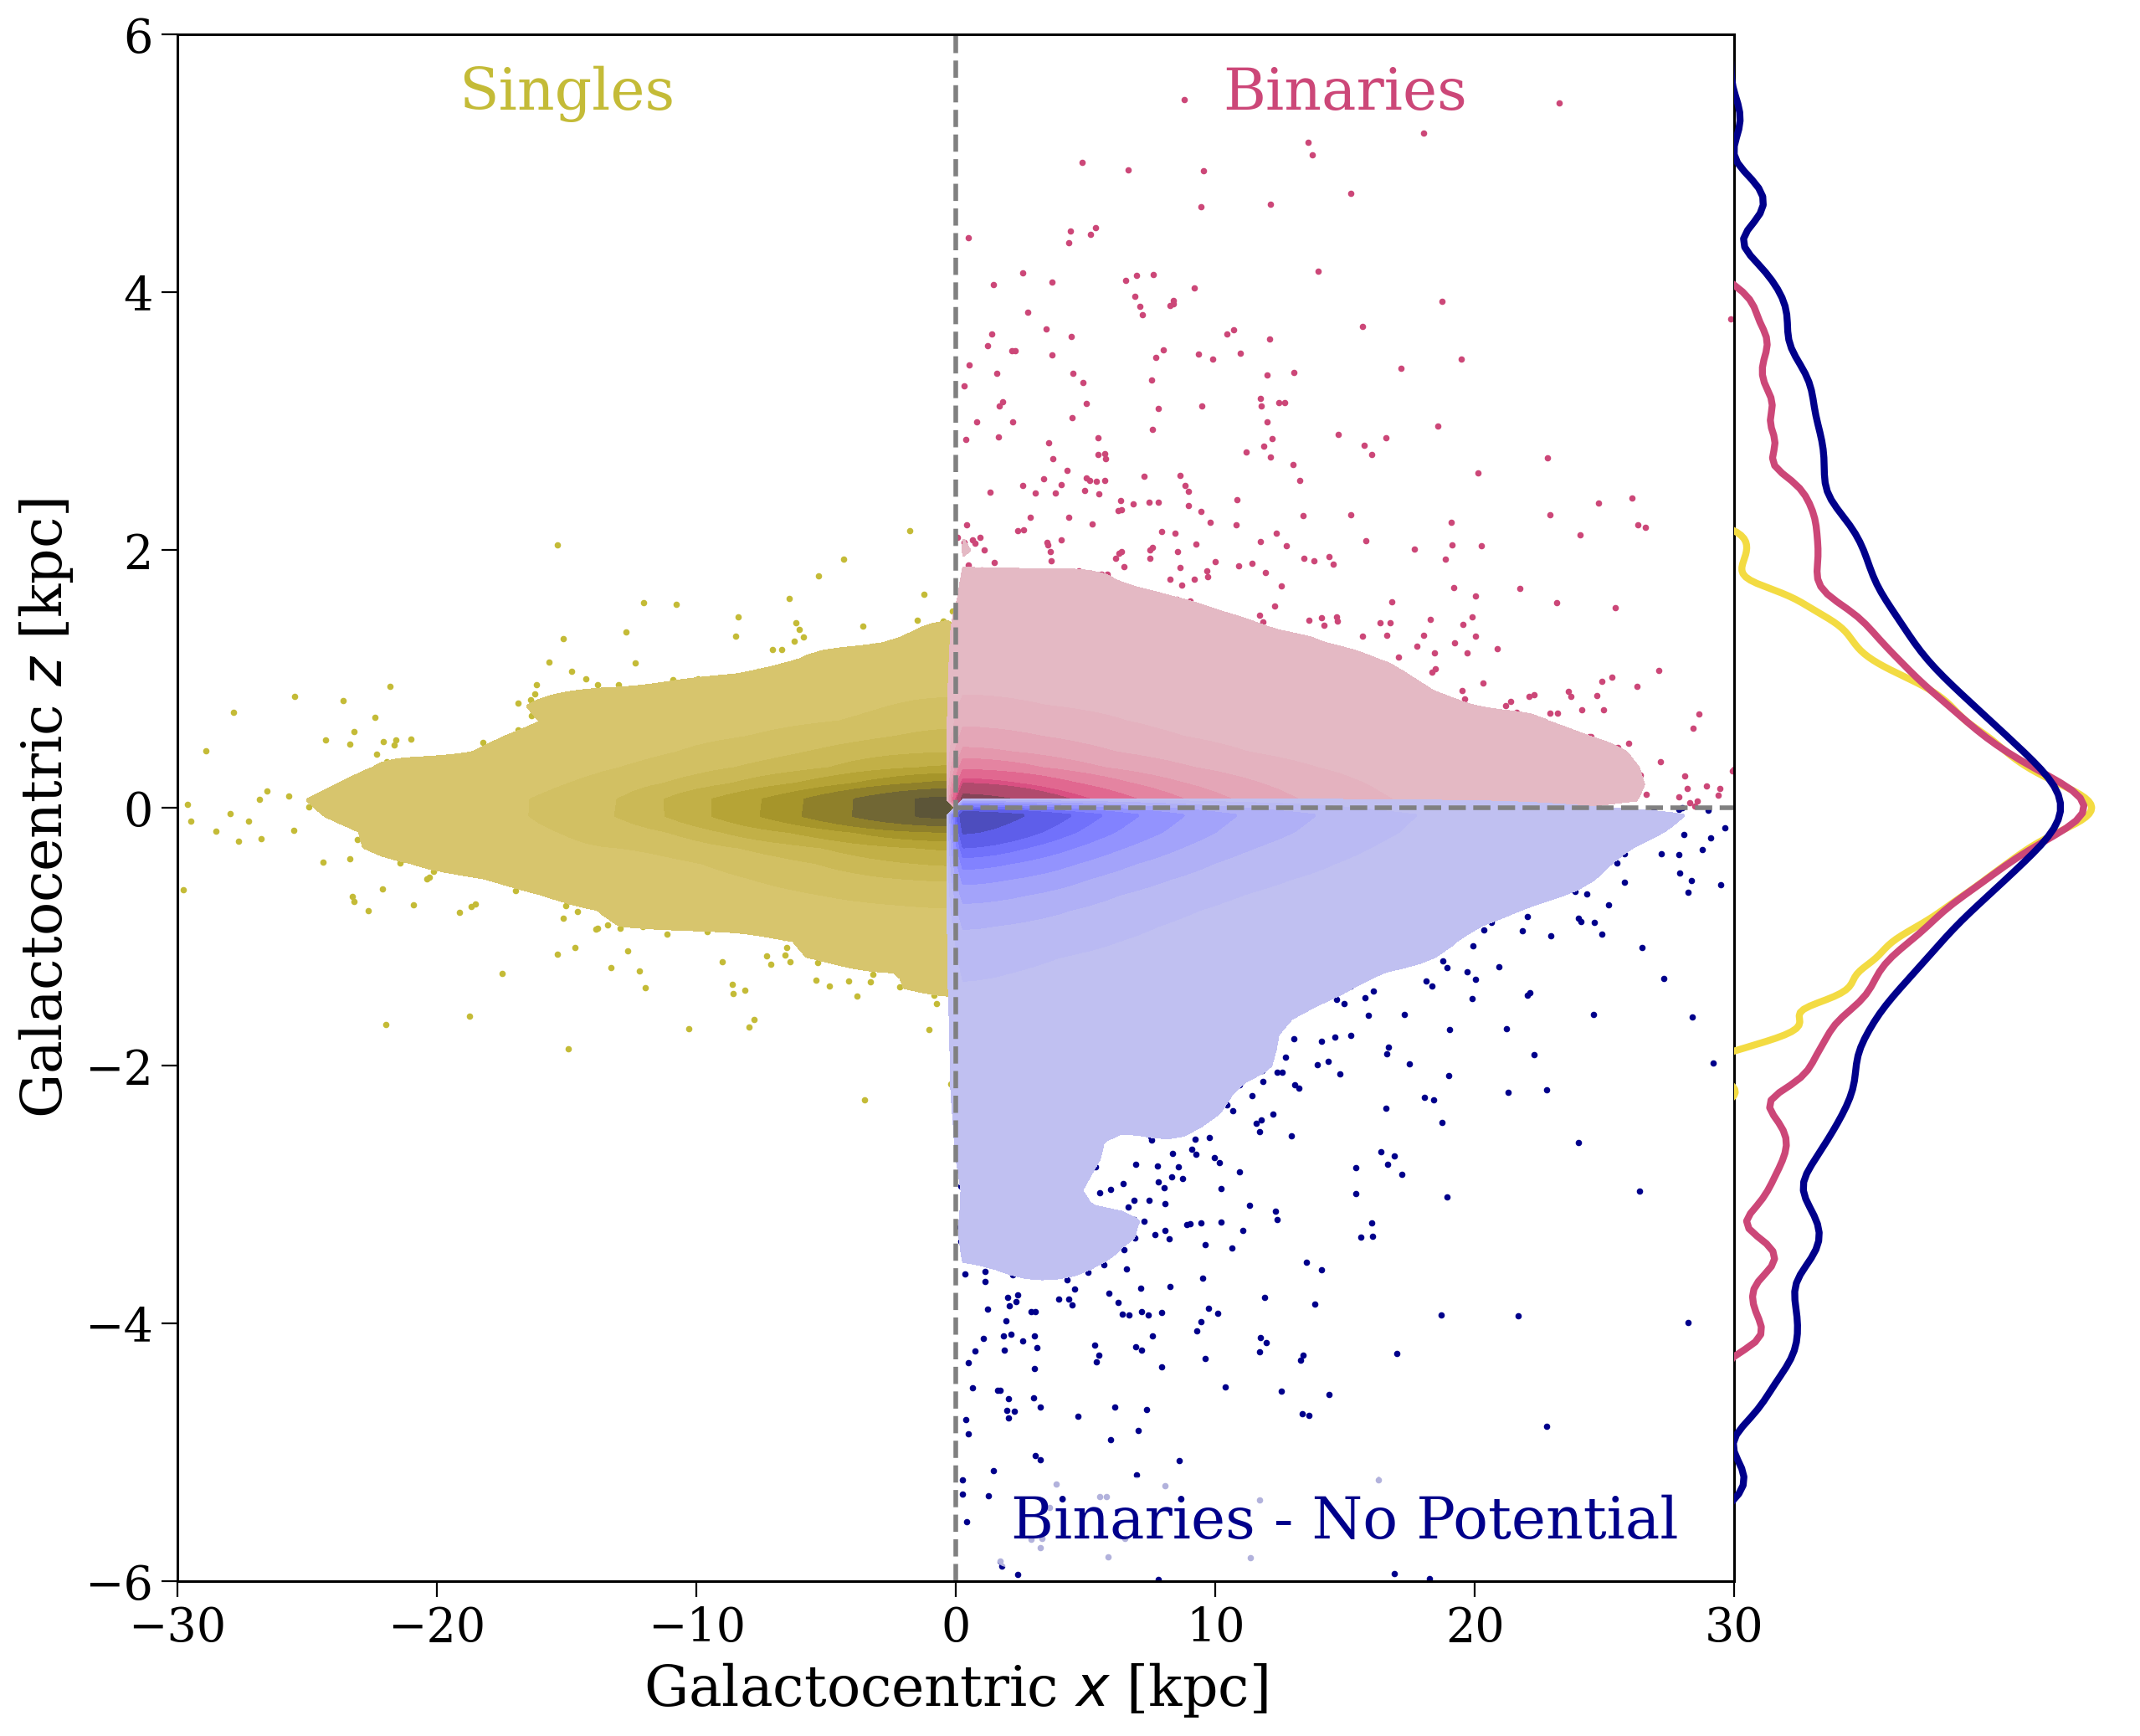

In [27]:
import matplotlib.cm as cm

# define colours for the different population
colours = [cm.cividis(0.95), cm.plasma(0.5), "darkblue"]

# iso-probability levels for the density plots
iso_levels = np.linspace(0.021, 1, 10)

xlims = (min(x_range).value, max(x_range).value)
zlims = (min(z_range).value, max(z_range).value)
    
fig, axes = plt.subplots(1, 2, figsize=(15, 12),
                         gridspec_kw={"width_ratios": [4, 1]})

fig.subplots_adjust(hspace=0, wspace=0)

lw = 3
for k, c in zip(data, colours):
    sns.kdeplot(y=data[k]["z"], lw=lw, color=c, ax=axes[1], bw_adjust=1.5)
axes[1].set_xscale("log")
axes[1].set_xlim(left=1e-3)

axes[0].scatter(-np.abs(data["singles"]["x"]), data["singles"]["z"], s=3, color="#c4bb37", rasterized=True)
axes[0].scatter(np.abs(data["binaries"]["x"]), np.abs(data["binaries"]["z"]),
                s=3, color=colours[1], rasterized=True)
axes[0].scatter(np.abs(data["binaries_no_pot"]["x"]), -np.abs(data["binaries_no_pot"]["z"]),
                s=3, color=colours[2], rasterized=True)

for i, k in enumerate(data):
    cnt = axes[0].contourf(X, Z, data[k]["density"], _iso_level_to_levels(data[k]["density"], iso_levels),
                 cmap=sns.distributions._DistributionPlotter()._cmap_from_color(colours[i]))
    cnt.set_edgecolor("face")

axes[0].set_xlabel(r"Galactocentric $x$ [kpc]", fontsize=1.2*fs)
axes[0].set_ylabel(r"Galactocentric $z$ [kpc]", fontsize=1.2*fs)
axes[0].tick_params(axis="both", which="major", labelsize=fs)

axes[0].annotate(f"Singles", xy=(0.25, 0.98),
            xycoords="axes fraction", ha="center", va="top",
                 color="#c4bb37", fontsize=1.25*fs)
axes[0].annotate(f"Binaries", xy=(0.75, 0.98),
            xycoords="axes fraction", ha="center", va="top",
                 color=colours[1], fontsize=1.25*fs)
axes[0].annotate(f"Binaries - No Potential", xy=(0.75, 0.02),
            xycoords="axes fraction", ha="center", va="bottom",
                 color=colours[2], fontsize=1.25*fs,
                 bbox=dict(boxstyle="round", facecolor="white",
                           edgecolor="none", alpha=0.7))

axes[1].axis("off")

axes[0].set_xlim(xlims)
axes[0].set_ylim(zlims)
axes[1].set_ylim(zlims)

axes[0].axvline(0, color="grey", linestyle="--", lw=2)
axes[0].axhline(0, 0.5, 1, color="grey", linestyle="--", lw=2)

plt.savefig("plots/bin_pot_effects.pdf", bbox_inches="tight", format="pdf")

plt.show()

## Discussion and explanations

So what do we see? Comparing first the single stars and the binaries, the scale height of the stars significantly increases, with many more outliers at large galactic heights. You can also note a slight increase in the radial extent of the systems. **Binary interactions cause an increase in the scale height of the stars**. This is because secondaries are ejected from binaries with their orbital velocity after a primary star going supernova. This lets them reach large distances from star forming regions that single stars could not otherwise achieve without dynamical encounters.

Additionally, comparing the binary stars with and without the galactic potential it is clear that **the galactic potential decelerates stars and neglecting it results in misleading conclusions about the scale height**. The large scale height is because ejected stars will keep moving in a straight line without the presence of a galactic potential.